# competition 2 scatch notebooks

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats
sns.set()
%matplotlib inline
from Modules import read_data


In [2]:
df , y = read_data('../default_of_credit_card_clients.xls')
df.head()


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#change the 'EDUCATION' values
df['EDUCATION'] = df['EDUCATION'].replace({1: 'Graduate School', 2: 'University', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Other', 0: 'Other'})

#change the 'SEX' values
df['SEX'] = df['SEX'].replace({1: 'Male', 2:'Female'})

#change the 'MARRIAGE' values
df['MARRIAGE'] = df['MARRIAGE'].replace({2: 'Non-married', 1: 'Married', 3: 'Non-married', 0: 'Non-married'})

df = pd.get_dummies(df)
df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT5,PAY_AMT6,Y,SEX_Female,SEX_Male,EDUCATION_Graduate School,EDUCATION_Other,EDUCATION_University,MARRIAGE_Married,MARRIAGE_Non-married
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,1,1,0,0,0,1,1,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,0,2000,1,1,0,0,0,1,0,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,5000,0,1,0,0,0,1,0,1
4,50000,37,0,0,0,0,0,0,46990,48233,...,1069,1000,0,1,0,0,0,1,1,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,689,679,0,0,1,0,0,1,1,0


Here we will build a baseline model, in which we will oversample the target feature to ensure balance in its classes. 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Y', axis = 1)
y = df['Y']
X.head()

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=2019)

#begin oversampling
oversample = pd.concat([X_train,y_train],axis=1)
max_size = oversample['Y'].value_counts().max()
lst = [oversample]

for class_index, group in oversample.groupby('Y'):
        lst.append(group.sample(max_size-len(group), replace=True))
X_train = pd.concat(lst)
y_train=pd.DataFrame.copy(X_train['Y'])
del X_train['Y']

In [5]:
#ensure that above worked
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Y, dtype: float64

In [6]:
#establish baseline model to tweak
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_jobs=-1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(f"single run validation accuracy score: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))

single run validation accuracy score: 0.8066666666666666
             precision    recall  f1-score   support

          0       0.85      0.92      0.88      5906
          1       0.56      0.40      0.47      1594

avg / total       0.79      0.81      0.79      7500



In order to try and make a better model, we will try a random search of hyperparameters of a Random Forest to see what values our random search yields. From there, we can then use a narrower Grid search to find our best performing model, which will be our model to help find the best features.

In [7]:
#try changing the number of trees

clf1 = clf = RandomForestClassifier(n_estimators = 20,n_jobs=-1, oob_score=True)

clf1.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print(f"single run training accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"single run validation accuracy: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_pred))

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


single run training accuracy: 0.99902623439111
single run validation accuracy: 0.8113333333333334
             precision    recall  f1-score   support

          0       0.85      0.92      0.88      5906
          1       0.56      0.40      0.47      1594

avg / total       0.79      0.81      0.79      7500



This slightly boosted our score, so let's try more trees. 

In [8]:
#try changing the number of trees

clf1 = clf = RandomForestClassifier(n_estimators = 80,n_jobs=-1, oob_score=True)

clf1.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print(f"single run training accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"single run validation accuracy: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_pred))

single run training accuracy: 0.9994844770305877
single run validation accuracy: 0.8170666666666667
             precision    recall  f1-score   support

          0       0.85      0.92      0.88      5906
          1       0.56      0.40      0.47      1594

avg / total       0.79      0.81      0.79      7500



This did not help again, so now we will try a Grid search

In [9]:
from sklearn.model_selection import GridSearchCV

#define number of trees 
n_estimators = [10, 20, 40, 80]

#define min number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'min_samples_leaf': min_samples_leaf
              }


In [11]:
#perform the grid seach, using 3-fold cross_validation


clf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=clf, param_grid=random_grid,
                         scoring = 'precision',
                         cv = 3,
                         n_jobs = -1
                              )

#fit the model
%timeit rf_grid.fit(X_train, y_train)

1min 8s ± 2.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
rf_grid.best_params_

{'min_samples_leaf': 1, 'n_estimators': 40}

In [17]:
#use these parameters for final model

clf_final = RandomForestClassifier(min_samples_leaf= 1, n_estimators= 40,
                                   n_jobs = -1
                                  )

clf_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
y_pred_final = clf_final.predict(X_val)

print(classification_report(y_val, y_pred_final))
print()

             precision    recall  f1-score   support

          0       0.86      0.91      0.89      5906
          1       0.58      0.44      0.50      1594

avg / total       0.80      0.81      0.80      7500




## Feature importance

For this next part, we are going to compare different ways of feature importance measures. Specifically, we'll look at what sklearn calculates, and then we will use two independent techniques: Local Interpretable Model-Agnostic Explantions (LIME), and Shapley values. Both will be briefly explaned in theory and will be utilized via independent 3rd party libraries. 

To start, we will use sklearn's built in feature importance measures with our fully-built Random Forest model. 

Text(0,0.5,'Feature')

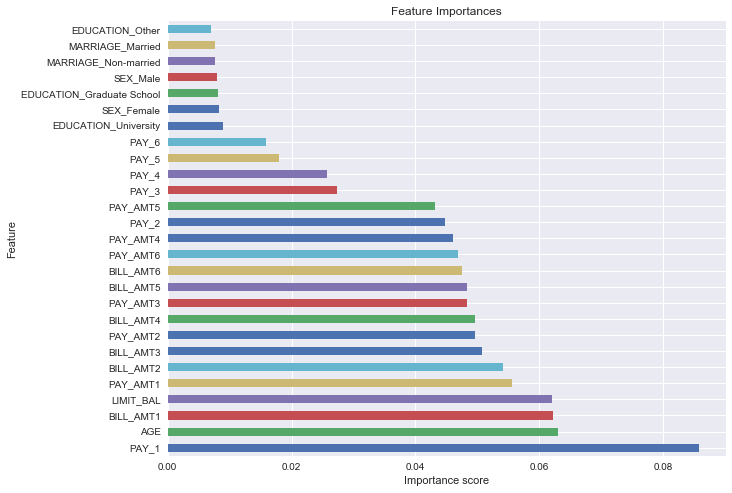

In [26]:
plt.figure(figsize=(10,8))

feature_imp = pd.Series(clf_final.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp.plot(kind = 'barh')
plt.title("Feature Importances")
plt.xlabel('Importance score')
plt.ylabel('Feature')

From this chart, we can see that the most important feature in the model is 'PAY_1', the amount one pays in the month before the current month. Then, there are many features that have a similar importance to each other, with a drop off in importance starting with 'PAY_6'. From a wholistic perspective, it seems the only really important feature about a customer is his or her age. The more important features are more so about the bill amounts and the payment amounts. It's all about the money!

This, of course, is useful, but one question that the modeler needs to always ask themselves is how much can he or she trust these findings? First off, do these findings make sense? Is age really the only important attributea about a customer? Second of all, we don't know for sure how the values of the features impact the model's thinking. For instance, could it be that the model acutally found that younger customers had a _lower_ chance of defaulting, when in the real world it could be the complete opposite? If this were the case, one would not have complete trust that this model is learning the appropriate patterns in the data; it might be performing well due to false findings.

In order to ensure our models findings, it would be helpful if we could see how the values of the features impact the model's predictions. From this idea we introduce LIME,

heloo

In [21]:
# set up random search

from sklearn.model_selection import RandomizedSearchCV

#define number of trees 
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 20)]

#define number of features to use at every split
#max_features = ['auto', .60]

#define max depth in trees
#max_depth = [int(t) for t in np.linspace(start = 10, stop = 100, num = 10)]

#define min number of samples to split a node
#min_samples_split = [2, 5, 8]

#define min number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

#define method of sample selection for each tree
#bootstrap = [True, False]


#create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
                }



In [22]:

#perform the random seach, using 3-fold cross_validation
#we'll search over 100 different combinations

clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 100, cv = 3,
                               random_state = 2019, n_jobs = -1
                              )

#fit the model
rf_random.fit(X, y)



KeyboardInterrupt: 

From the UCI dataset website:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005;
- X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 